**Name:** Fatima Azfar<br>
**Roll No:** 20L-1027<br>
**Section:** BDS-8A<br>

**Note:** The dataset (even though is called tiny) was too large for my system to train on, the dataset had 200 classes with approx 10k images in every class. I downscaled to picking 100 images from 10 classes only.<br>
The dataset used is **ImageNet** which I downloaded from the official ImageNet platform after registering.

# Imports

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load Tiny ImageNet Data

In [28]:
def load_dataset(dataset_dir, split='train', images_per_class=100, selected_classes=None):
    assert split in ['train', 'val'], "split must be 'train' or 'val'"
    split_dir = os.path.join(dataset_dir, split)

    images = []
    labels = []

    if split == 'train':
        for label_dir in os.listdir(split_dir):
            class_id = label_dir  # 'nXXXXXX'
            if selected_classes is not None and class_id not in selected_classes:
                continue  # Skip classes not in the selected subset
            class_dir = os.path.join(split_dir, label_dir, 'images')
            class_images = os.listdir(class_dir)[:images_per_class]  # Selecting only 100 images per class
            for image_file in class_images:
                image_path = os.path.join(class_dir, image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)
    elif split == 'val':
        val_annotations_path = os.path.join(split_dir, 'val_annotations.txt')
        with open(val_annotations_path, 'r') as f:
            val_annotations = f.readlines()
        
        class_counts = {}
        for line in val_annotations:
            items = line.strip().split('\t')
            image_file, class_id = items[0], items[1]
            if selected_classes is not None and class_id not in selected_classes:
                continue
            if class_id not in class_counts:
                class_counts[class_id] = 0
            if class_counts[class_id] < images_per_class:
                class_counts[class_id] += 1
                image_path = os.path.join(split_dir, 'images', image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)

    images = np.array(images)
    if labels:
        unique_labels = sorted(list(set(labels)))
        label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
        labels = np.array([label_to_id[label] for label in labels])
    else:
        labels = None

    return images, labels

dataset_dir = 'tiny-imagenet-200'
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']

train_images, train_labels = load_dataset(dataset_dir, 'train', images_per_class=100, selected_classes=selected_classes)
val_images, val_labels = load_dataset(dataset_dir, 'val', images_per_class=100, selected_classes=selected_classes)

train_images, val_images = train_images / 255.0, val_images / 255.0

# AlexNet

In [33]:
def alexnet_model(input_shape=(64, 64, 3), num_classes=10):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0, alpha=0.00002, beta=0.75)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0, alpha=0.00002, beta=0.75)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Fourth Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Fifth Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flattening Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [38]:
# learning rate schedule
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 75:
        lr *= 0.5
    elif epoch > 100:
        lr *= 0.1
    return lr

num_classes = 10

train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes=num_classes)

# preprocessing the training and validation data
train_datagen = ImageDataGenerator(
    rotation_range=20,       # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,   # Shifting the image horizontally
    height_shift_range=0.2,  # Shifting the image vertically
    shear_range=0.2,         # Shearing transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Horizontal flipping
    fill_mode='nearest'      # Filling the area outside the boundaries with the nearest value
)

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels_one_hot, batch_size=128)

val_datagen = ImageDataGenerator()
val_datagen.fit(val_images)
val_generator = val_datagen.flow(val_images, val_labels_one_hot, batch_size=128)

model = alexnet_model(input_shape=(64, 64, 3), num_classes=num_classes)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 128,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(val_images) // 128,
    callbacks=[lr_scheduler]
)

Epoch 1/120
7/7 [==============================] - 15s 1s/step - loss: 2.3031 - accuracy: 0.0768 - val_loss: 2.3024 - val_accuracy: 0.1224 - lr: 0.0100
Epoch 2/120
7/7 [==============================] - 5s 759ms/step - loss: 2.3025 - accuracy: 0.0998 - val_loss: 2.3027 - val_accuracy: 0.1250 - lr: 0.0100
Epoch 3/120
7/7 [==============================] - 6s 761ms/step - loss: 2.3029 - accuracy: 0.0826 - val_loss: 2.3024 - val_accuracy: 0.1016 - lr: 0.0100
Epoch 4/120
7/7 [==============================] - 5s 764ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3025 - val_accuracy: 0.0911 - lr: 0.0100
Epoch 5/120
7/7 [==============================] - 6s 796ms/step - loss: 2.3024 - accuracy: 0.1009 - val_loss: 2.3021 - val_accuracy: 0.1146 - lr: 0.0100
Epoch 6/120
7/7 [==============================] - 6s 822ms/step - loss: 2.3023 - accuracy: 0.1101 - val_loss: 2.3023 - val_accuracy: 0.1094 - lr: 0.0100
Epoch 7/120
7/7 [==============================] - 6s 760ms/step - loss: 2.302

# Model Training Visualizations
To assess the learning of the model

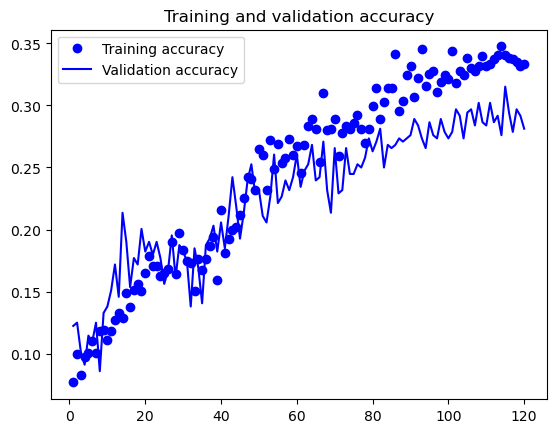

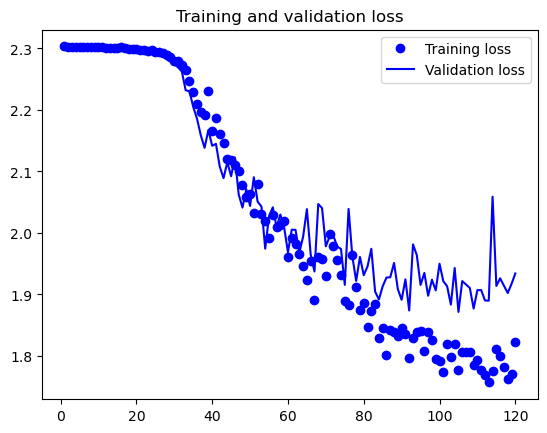

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Top k val error & accuracy

In [40]:
# predictions on the validation set
val_predictions = model.predict(val_images)

# top-1 error rate
val_top1_errors = np.argmax(val_predictions, axis=1) != val_labels
val_top1_error_rate = np.mean(val_top1_errors)
val_top1_accuracy = 1 - val_top1_error_rate
print("Validation Top-1 Error Rate:", val_top1_error_rate)
print("Validation Top-1 Accuracy:", val_top1_accuracy)

# top-5 error rate
val_top5_errors = np.ones_like(val_top1_errors)
for i in range(len(val_predictions)):
    val_top5_indices = np.argsort(val_predictions[i])[-5:]
    if val_labels[i] in val_top5_indices:
        val_top5_errors[i] = 0
val_top5_error_rate = np.mean(val_top5_errors)
val_top5_accuracy = 1 - val_top5_error_rate
print("Validation Top-5 Error Rate:", val_top5_error_rate)
print("Validation Top-5 Accuracy:", val_top5_accuracy)

16/16 [==============================] - 3s 112ms/step
Validation Top-1 Error Rate: 0.706
Validation Top-1 Accuracy: 0.29400000000000004
Validation Top-5 Error Rate: 0.216
Validation Top-5 Accuracy: 0.784
